# A2C Model for RLPaint

## Imports

In [1]:
# Full imports
import gym
import cv2

# Partial imports 
from tqdm.notebook import tqdm, trange
from telesketch.envs.discrete_telesketch import DiscreteTelesketchEnv

# Aliased imports
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
import numpy as np
from typing import Any, List, Sequence, Tuple

2023-01-16 23:25:58.173776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 23:25:58.363236: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-16 23:25:58.409030: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-16 23:26:00.515435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

## Bootstrap

In [2]:
# Remember to export to export "LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/"" if using linux
# Drop numa errors in term: "for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done"

# Check if we have GPU
tf.config.list_physical_devices('GPU')

2023-01-16 23:26:04.871535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 23:26:04.885888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 23:26:04.887770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Constants

In [3]:
# Define min epsilon so we don't run into inf
# on divisions
EPS = np.finfo(np.float32).eps.item()

# Use Huber loss for crisitic as it's less sensitive to outliers than MSE
HUBER_LOSS = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

# Define patch size
# Must be odd
PATCH_SIZE = (31, 31)

## Environment Interaction

In [4]:
class Trainer:
    def __init__(self, env: gym.Env, model: tf.keras.Model, max_steps=300) -> None:
        # Make internal copy of params
        self._env = env
        self._model = model
        self._max_steps = max_steps

    # Define aux methods for vectorization
    def _aux_np_step(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        state, reward, done, _ = self._env.step(int(action))

        return (
            state["loc"],
            state["ref"].astype(np.float32),
            state["cnv"].astype(np.float32),
            state["ref_patch"].astype(np.float32),
            state["cnv_patch"].astype(np.float32),
            np.array(reward, np.float32),
            np.array(done, np.int32)
        )

    def _tf_step(self, action: tf.Tensor) -> List[tf.Tensor]:
        return tf.numpy_function(self._aux_np_step, [action], [tf.int32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.int32])
    

    def run_episode():
        log_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

        # Init agent and get state
        pass
        
        




In [5]:
class ActorCritic(tf.keras.Model):
    def __init__(self, env: gym.Env) -> None:
        # Call super to properly init
        super().__init__()

        # Define global and local inputs
        global_input = env.observation_space["cnv"] + (1,)
        local_input = env.observation_space["cnv_patch"] + (1,)
        
        # Define global ref
        gref_input = keras.Input(shape=global_input)
        gref_cnn_1 = keras.layers.Conv2D(32, (8, 8))(gref_input)
        gref_pool_1 = keras.layers.MaxPool2D((16, 16))(gref_cnn_1)
        gref_flatten = keras.layers.Flatten()(gref_pool_1)
        gref_out = keras.layers.Dense(8)(gref_flatten)

        # Define global canvas
        gcnv_input = keras.Input(shape=global_input)
        gcnv_cnn_1 = keras.layers.Conv2D(32, (8, 8))(gcnv_input)
        gcnv_pool_1 = keras.layers.MaxPool2D((16, 16))(gcnv_cnn_1)
        gcnv_flatten = keras.layers.Flatten()(gcnv_pool_1)
        gcnv_out = keras.layers.Dense(8)(gcnv_flatten)

        # Define local ref
        lref_input = keras.Input(shape=local_input)
        lref_cnn_1 = keras.layers.Conv2D(32, (8, 8))(lref_input)
        lref_flatten = keras.layers.Flatten()(lref_cnn_1)
        lref_out = keras.layers.Dense(8)(lref_flatten)

        # Define local canvas
        lcnv_input = keras.Input(shape=local_input)
        lcnv_cnn_1 = keras.layers.Conv2D(32, (8, 8))(lcnv_input)
        lcnv_flatten = keras.layers.Flatten()(lcnv_cnn_1)
        lcnv_out = keras.layers.Dense(8)(lcnv_flatten)

        # Concatenate ref and canvas
        conc = keras.layers.Concatenate()([gref_out, gcnv_out, lref_out, lcnv_out])
        actor_out = keras.layers.Dense(8)(conc)
        critic_out = keras.layers.Dense(1)(conc)

        # Define model
        self.model = keras.Model([gref_input, gcnv_input, lref_input, lcnv_input], [actor_out, critic_out])
        

    def call(self, gref: tf.Tensor, gcnv: tf.Tensor, lref: tf.Tensor, lcnv: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        # Expand inputs
        inputs = [tf.expand_dims(x, 0) for x in [gref, gcnv, lref, lcnv]]

        # Apply model layers
        actor_out, value = self.model(inputs)

        # Compute distribution of actions for actor and pick one and corresponding log_prob
        action_dist = tfp.distributions.Categorical(logits=actor_out, dtype=tf.float32)
        action = action_dist.sample()

        return action, action_dist.log_prob(action), value
        

In [6]:
# Ref canvas
IMG_SIZE = 256
PATCH_SIZE = 16
ref_canvas = np.full((IMG_SIZE, IMG_SIZE, 3), 255, dtype=np.uint8)
ref_canvas = cv2.line(ref_canvas, (0, 0), (IMG_SIZE, IMG_SIZE), (0, 0, 0), 5)

# Sim func
def rmse_sim(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [7]:
# Init env
env = DiscreteTelesketchEnv(ref_canvas, rmse_sim, 20, 5, patch_size=(PATCH_SIZE, PATCH_SIZE), render_mode="image")
x = env.reset()


In [17]:
trainer = Trainer(env, None, 300)

input_step = trainer._tf_step(7)

In [18]:
input_step

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([14, 14])>,
 <tf.Tensor: shape=(250, 250), dtype=float32, numpy=
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(250, 250), dtype=float32, numpy=
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>,
 <tf.Tensor: shape=(25, 25), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 

In [70]:
trainer._env.observation_space

Dict('cnv': Box(0.0, 1.0, (250, 250), float32), 'cnv_patch': Box(0.0, 1.0, (25, 25), float32), 'loc': Box(0, 250, (2,), int64), 'ref': Box(0.0, 1.0, (250, 250), float32), 'ref_patch': Box(0.0, 1.0, (25, 25), float32))

In [71]:
# Define global ref
gref_input = keras.Input(shape=env.observation_space["cnv"].shape[:2] + (1,))
gref_cnn_1 = keras.layers.Conv2D(32, (8, 8))(gref_input)
gref_pool_1 = keras.layers.MaxPool2D((16, 16))(gref_cnn_1)
gref_flatten = keras.layers.Flatten()(gref_pool_1)
gref_out = keras.layers.Dense(8)(gref_flatten)

# Define global canvas
gcnv_input = keras.Input(shape=env.observation_space["cnv"].shape[:2] + (1,))
gcnv_cnn_1 = keras.layers.Conv2D(32, (8, 8))(gcnv_input)
gcnv_pool_1 = keras.layers.MaxPool2D((16, 16))(gcnv_cnn_1)
gcnv_flatten = keras.layers.Flatten()(gcnv_pool_1)
gcnv_out = keras.layers.Dense(8)(gcnv_flatten)

# Define local ref
lref_input = keras.Input(shape=env.observation_space["cnv_patch"].shape[:2] + (1,))
lref_cnn_1 = keras.layers.Conv2D(32, (8, 8))(lref_input)
lref_flatten = keras.layers.Flatten()(lref_cnn_1)
lref_out = keras.layers.Dense(8)(lref_flatten)

# Define local canvas
lcnv_input = keras.Input(shape=env.observation_space["cnv_patch"].shape[:2] + (1,))
lcnv_cnn_1 = keras.layers.Conv2D(32, (8, 8))(lcnv_input)
lcnv_flatten = keras.layers.Flatten()(lcnv_cnn_1)
lcnv_out = keras.layers.Dense(8)(lcnv_flatten)

# Concatenate ref and canvas
conc = keras.layers.Concatenate()([gref_out, gcnv_out, lref_out, lcnv_out])
actor_out = keras.layers.Dense(8)(conc)
critic_out = keras.layers.Dense(1)(conc)

# Define model
model = keras.Model([gref_input, gcnv_input, lref_input, lcnv_input], [actor_out, critic_out])


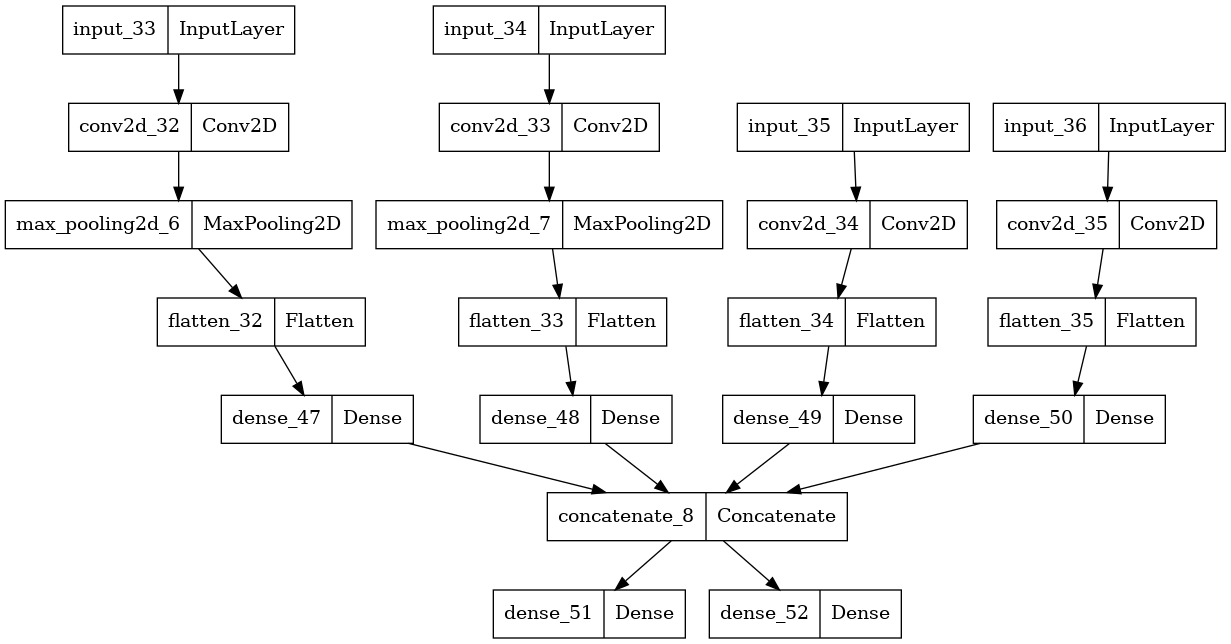

In [72]:
keras.utils.plot_model(model)

In [73]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_34 (InputLayer)          [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 243, 243, 32  2080        ['input_33[0][0]']               
                                )                                                           

In [74]:
inputs= [tf.expand_dims(x, 0) for x in input_step[1:5]]

model(inputs)

[<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.27566522, -0.13555342,  0.12616856,  0.22195649,  0.29273075,
         -0.06204719,  0.6958765 ,  0.18322809]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1390075]], dtype=float32)>]